# LLM Evaluation with Confusion Matrix

In [4]:
# Device Check
import torch
import transformers
import peft
import datasets
import sklearn
import numpy as np
import evaluate

print("=== Environment Pre-Check ===")
print(f"Torch version:          {torch.__version__}")
print(f"Transformers version:   {transformers.__version__}")
print(f"PEFT version:           {peft.__version__}")
print(f"Datasets version:       {datasets.__version__}")
print(f"Scikit-learn version:   {sklearn.__version__}")
print(f"NumPy version:          {np.__version__}")
print(f"Evaluate version: {evaluate.__version__}")

print("\n=== Device Check ===")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device in use:  {'cuda' if torch.cuda.is_available() else 'cpu'}")


=== Environment Pre-Check ===
Torch version:          2.5.1
Transformers version:   4.57.3
PEFT version:           0.17.1
Datasets version:       4.4.1
Scikit-learn version:   1.5.1
NumPy version:          1.26.4
Evaluate version: 0.4.6

=== Device Check ===
CUDA available: False
Device in use:  cpu


In [1]:
import matplotlib, sklearn, pandas, seaborn, transformers, datasets, evaluate

print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("seaborn:", seaborn.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)


C:\Users\marky\anaconda3\envs\llm_eval_confusion_matrix\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Matplotlib: 3.9.2
scikit-learn: 1.5.1
pandas: 2.3.3
seaborn: 0.13.2
transformers: 4.57.3
datasets: 4.4.1
evaluate: 0.4.6


## 1. Dataset Preparation

In [6]:
from datasets import load_dataset, DatasetDict

# Load IMDb dataset
raw = load_dataset("imdb")

# Create validation split from train
splits = raw["train"].train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = splits["train"]
val_ds = splits["test"]
test_ds = raw["test"]

dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

# ⚡ For CPU debugging, shrink dataset
dataset_small = DatasetDict({
    "train": dataset["train"].select(range(500)),
    "validation": dataset["validation"].select(range(200)),
    "test": dataset["test"].select(range(100))
})
dataset = dataset_small

## 2. Tokenization & Formatting

In [7]:
from transformers import AutoTokenizer

model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=False)

def preprocess_fn(examples):
    inputs = [f"review: {t}" for t in examples["text"]]
    labels_text = ["negative" if l == 0 else "positive" for l in examples["label"]]
    enc = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    enc_targets = tokenizer(text_target=labels_text, max_length=5, truncation=True, padding="max_length")
    enc["labels"] = enc_targets["input_ids"]
    return enc

tokenized = dataset.map(preprocess_fn, batched=True, remove_columns=dataset["train"].column_names)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 100/100 [00:00<00:00, 1142.37 examples/s]


## 3. Baseline Comparison (No Fine‑Tuning)

In [8]:
# baseline
from transformers import pipeline, AutoModelForSeq2SeqLM

baseline_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
baseline_pipe = pipeline(
    "text2text-generation",
    model=baseline_model,
    tokenizer=tokenizer,
    device=-1
)

def baseline_predict(texts):
    prompts = [f"review: {t}" for t in texts]
    # Tokenize with truncation to avoid >512 tokens
    enc = tokenizer(prompts, max_length=256, truncation=True, return_tensors="pt", padding=True)
    outs = baseline_model.generate(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        max_new_tokens=3
    )
    preds_str = tokenizer.batch_decode(outs, skip_special_tokens=True)
    return [1 if "positive" in s.lower() else 0 for s in preds_str]

sample = dataset["validation"].select(range(200))
baseline_preds = baseline_predict(sample["text"])
baseline_refs = sample["label"]

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

print("\nBaseline (no fine-tuning) on 200 validation samples:")
print("Accuracy:", accuracy.compute(predictions=baseline_preds, references=baseline_refs)["accuracy"])
print("Precision:", precision.compute(predictions=baseline_preds, references=baseline_refs, average="binary")["precision"])
print("Recall:", recall.compute(predictions=baseline_preds, references=baseline_refs, average="binary")["recall"])
print("F1:", f1.compute(predictions=baseline_preds, references=baseline_refs, average="binary")["f1"])


Device set to use cpu



Baseline (no fine-tuning) on 200 validation samples:
Accuracy: 0.49
Precision: 0.0
Recall: 0.0
F1: 0.0


C:\Users\marky\anaconda3\envs\llm_eval_confusion_matrix\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. PEFT + LoRA Setup

In [9]:
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850


## 5. Training Configuration

In [10]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer
)

trainer.train()


C:\Users\marky\AppData\Local\Temp\ipykernel_17488\4087586163.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.775500,0.116716


TrainOutput(global_step=125, training_loss=3.8240443954467773, metrics={'train_runtime': 114.7051, 'train_samples_per_second': 4.359, 'train_steps_per_second': 1.09, 'total_flos': 17030971392000.0, 'train_loss': 3.8240443954467773, 'epoch': 1.0})

## 6. Evaluation Metrics

In [11]:
from sklearn.metrics import classification_report

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def to_int_labels(strs):
    return [1 if "positive" in s.lower() else 0 for s in strs]

# Validation evaluation
val_out = trainer.predict(tokenized["validation"])
val_preds_str = tokenizer.batch_decode(val_out.predictions, skip_special_tokens=True)
val_labels_str = tokenizer.batch_decode(val_out.label_ids, skip_special_tokens=True)

val_preds = to_int_labels(val_preds_str)
val_refs = to_int_labels(val_labels_str)

print("Validation metrics:")
print("Accuracy:", accuracy.compute(predictions=val_preds, references=val_refs)["accuracy"])
print("Precision:", precision.compute(predictions=val_preds, references=val_refs, average="binary")["precision"])
print("Recall:", recall.compute(predictions=val_preds, references=val_refs, average="binary")["recall"])
print("F1:", f1.compute(predictions=val_preds, references=val_refs, average="binary")["f1"])

print("\nClassification report (validation):")
print(classification_report(val_refs, val_preds, target_names=["negative", "positive"]))


Validation metrics:
Accuracy: 0.695
Precision: 0.9767441860465116
Recall: 0.4117647058823529
F1: 0.5793103448275863

Classification report (validation):
              precision    recall  f1-score   support

    negative       0.62      0.99      0.76        98
    positive       0.98      0.41      0.58       102

    accuracy                           0.69       200
   macro avg       0.80      0.70      0.67       200
weighted avg       0.80      0.69      0.67       200



## 7. Inference on Custom Reviews

In [12]:
def classify_review(text: str):
    prompt = f"review: {text}"
    gen = trainer.model.generate(**tokenizer(prompt, return_tensors="pt"), max_new_tokens=3)
    pred_str = tokenizer.decode(gen[0], skip_special_tokens=True)
    return "positive" if "positive" in pred_str.lower() else "negative"

# Clear positive case
print("Test 1:", classify_review("This movie was amazing!"))  # Expected: positive

# Clear negative case
print("Test 2:", classify_review("Terrible acting and a boring plot."))  # Expected: negative

# Ambiguous/mixed sentiment case
print("Test 3:", classify_review("The visuals were stunning, but the story was weak."))  # Model’s prediction may vary


Test 1: positive
Test 2: negative
Test 3: negative


## 8. Confusion Matrix

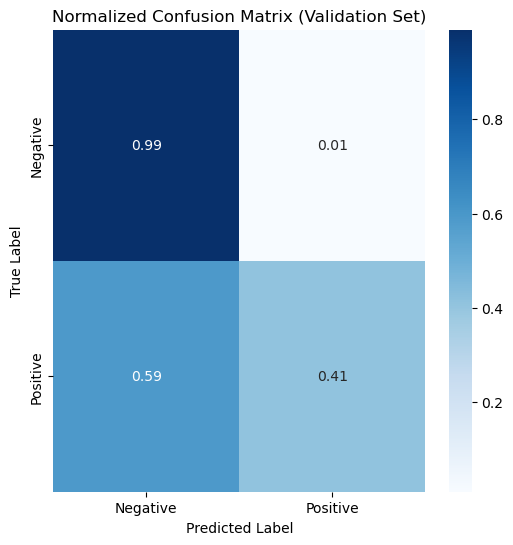

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the labels and predictions you already computed
y_true = val_refs   # ground truth labels
y_pred = val_preds  # model predictions

# Normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='true')

labels = ["Negative", "Positive"]

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
